### Import

In [693]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#plot
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

#technical analysis
import ta
import ta.momentum
import ta.volatility
import ta.volume

#### Ignore warnings

In [694]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [695]:
# df = pd.read_csv("./data/nasdaq/csv/TXN.csv", sep=',')
df = pd.read_csv("./data/nasdaq/csv/INTC.csv", sep=',')
# df = pd.read_csv("./data/nyse/csv/X.csv", sep=',')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.index = range(len(df))

df.tail()
df.set_index('Date', inplace=True)

all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(all_dates) 
df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']] = df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']].interpolate(method='linear')
df['Open'] = df['Close'].shift(1)
df['High'] = df[['High', 'Open', 'Close']].max(axis=1)
df['Low'] = df[['Low', 'Open', 'Close']].min(axis=1)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

### Add technical analysis indicators

#### RSI - Relative Strength Index

In [696]:
df['RSI7'] = ta.momentum.RSIIndicator(df['Close'], window=7).rsi()
df['RSI14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['RSI30'] = ta.momentum.RSIIndicator(df['Close'], window=30).rsi()
df['RSI50'] = ta.momentum.RSIIndicator(df['Close'], window=50).rsi()

# df['MEAN_RSI7_5'] = df['RSI7'].rolling(window=5).mean()
# df['MEAN_RSI14_5'] = df['RSI14'].rolling(window=5).mean()
# df['MEAN_RSI30_5'] = df['RSI30'].rolling(window=5).mean()
# df['MEAN_RSI50_5'] = df['RSI50'].rolling(window=5).mean()

# df['DRSI7'] = df['RSI7'].diff()
# df['DRSI14'] = df['RSI14'].diff()
# df['DRSI30'] = df['RSI30'].diff()

### EMA RSI

In [697]:
df['EMA7_RSI14'] = ta.trend.EMAIndicator(df['RSI14'], window=7).ema_indicator()
df['EMA7_RSI30'] = ta.trend.EMAIndicator(df['RSI30'], window=7).ema_indicator()

#### SMA - Simple Moving Average

In [698]:
df['SMA5'] = ta.trend.SMAIndicator(df['Close'], window=5).sma_indicator()
df['SMA10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()
df['SMA14'] = ta.trend.SMAIndicator(df['Close'], window=14).sma_indicator()
df['SMA30'] = ta.trend.SMAIndicator(df['Close'], window=30).sma_indicator()
df['SMA50'] = ta.trend.SMAIndicator(df['Close'], window=50).sma_indicator()

#### EMA - Exponential Moving Average

In [699]:
# df['EMA5'] = ta.trend.EMAIndicator(df['Close'], window=5).ema_indicator()
# df['EMA10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
df['EMA14'] = ta.trend.EMAIndicator(df['Close'], window=14).ema_indicator()
# df['EMA14'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

### KAMA - Kaufman's Adaptive Moving Average

In [700]:
# df['KAMA'] = ta.momentum.KAMAIndicator(close=df['Close']).kama()

### ADX - Average Directional Movement

In [701]:
df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14).adx()

### EMA ADX

In [702]:
df['EMA7_ADX'] = ta.trend.EMAIndicator(df['ADX'], window=7).ema_indicator()

### Bollinger Bands

In [703]:
bb = ta.volatility.BollingerBands(close=df['Close'])
df['HB'] = bb.bollinger_hband()
df['LB'] = bb.bollinger_lband()
df['MB'] = bb.bollinger_mavg()
df['%B'] = (df['Close'] - df['LB']) / (df['HB'] - df['LB'])
df['BBBandWidth'] = (df['HB'] - df['LB']) / df['MB']

In [704]:
#consecutive days above sma20
df['AboveSMA20'] = (df['Close'] > df['MB']).astype(int)
df['DASMA'] = 0
consecutive_count = 0
r = np.zeros(len(df), dtype=int)
for i in range(1, len(df)):
    if df['AboveSMA20'].iloc[i]:
        consecutive_count += 1
    else:
        consecutive_count = 0
    r[i] = consecutive_count
df['DASMA'] = r
df.drop(['AboveSMA20'], axis=1, inplace=True)

In [705]:
#consecutive days below sma20
df['BelowSMA20'] = (df['Close'] < df['MB']).astype(int)
df['DBSMA'] = 0
consecutive_count = 0
r = np.zeros(len(df), dtype=int)
for i in range(1, len(df)):
    if df['BelowSMA20'].iloc[i]:
        consecutive_count += 1
    else:
        consecutive_count = 0
    r[i] = consecutive_count
df['DBSMA'] = r
df.drop(['BelowSMA20'], axis=1, inplace=True)

### MACD

In [706]:
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['MACD_signal'] = ta.trend.MACD(df['Close']).macd_signal()
df['MACD_hist'] = ta.trend.MACD(df['Close']).macd_diff()

### Stochastic Oscillator

In [707]:
df['SO'] = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close']).stoch()

### On Balance Volume

In [708]:
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()

### Chaikin Money Flow

In [709]:
df['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume']).chaikin_money_flow()

### Visualize

In [710]:
start = 15500
# vdf = df
vdf = df[start:start+200]

fig = make_subplots(rows=8, cols=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.HB, name='Bollinger High Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.LB, name='Bollinger Low Band'), row=1, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.MB, name='Bollinger Middle Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA5, name='SMA5'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA10, name='SMA10'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA14, name='SMA14'), row=2, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA30, name='SMA30'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.EMA14, name='EMA14'), row=3, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.KAMA, name='KAMA'), row=3, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf['%B'], name='%B'), row=4, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.BBBandWidth, name='BandWidth'), row=5, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI30, name='RSI30'), row=6, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI14, name='RSI14'), row=7, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.ADX, name='ADX'), row=8, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Volume, name='Volume'), row=8, col=1)

fig.update_layout(
    autosize=False,
    width=1500,
    height=1500,
    margin=dict(l=30,r=30,b=30,
                t=30,pad=3
                ),
    paper_bgcolor="White",
)

### Trend

In [711]:
def calc_trend(df, n=5, threshold=0.01):
	trend = []	
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		future_mean = df['Close'].iloc[i+1:i+n+1].mean()
		current_close = df['Close'].iloc[i]
		if future_mean > current_close * (1 + threshold):
			trend.append('Up')
		elif future_mean < current_close * (1 - threshold):
			trend.append('Down')
		else:
			trend.append('Neutral')
	df['Trend'] = trend
	return df

In [712]:
def calc_trend_sma_ema(df, n=10, sma_threshold=0.01, ema_threshold=0.01):
	trend = []
	df['BBBandwidth_Q1'] = df['BBBandWidth'].rolling(window=50, min_periods=50).quantile(0.4)
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		future_sma10 = df['SMA10'].iloc[i + n]
		current_sma10 = df['SMA10'].iloc[i]
		future_sma14= df['SMA14'].iloc[i + n]
		current_sma14 = df['SMA14'].iloc[i]
		future_ema14 = df['EMA14'].iloc[i + n]
		current_ema14 = df['EMA14'].iloc[i]
		# future_kama = df['KAMA'].iloc[i + n]
		# current_kama = df['KAMA'].iloc[i]

		future_close = df['Close'].iloc[i + n]

		future_sma30 = df['SMA30'].iloc[i + n]

		# future_ema_rsi

		future_bandwidth = df['BBBandWidth'].iloc[i + n]
		future_bandwidth_q1 = df['BBBandwidth_Q1'].iloc[i + n]

		future_pb = df['%B'].iloc[i + n]
		# if (future_sma10 > current_sma10 * (1 + sma_threshold)) and (future_ema14 > current_ema14 * (1 + ema_threshold)) and (future_pb >= 0.7):
		# 	trend.append('Up')
		# elif (future_sma10 < current_sma10 * (1 - sma_threshold)) and (future_ema14 < current_ema14 * (1 - ema_threshold)) and (future_pb <= 0.3):
		# 	trend.append('Down')
		# elif (future_bandwidth < future_bandwidth_q1):
		# 	trend.append('Neutral')
		# else:
		# 	trend.append('Unknown')

		if future_close > future_sma14 * (1 + sma_threshold):
			trend.append('Up')
		elif future_close < future_sma14 * (1 - sma_threshold):
			trend.append('Down')
		elif (future_bandwidth < future_bandwidth_q1):
			trend.append('Neutral')
		else:
			trend.append('Unknown')
		
	assert(len(trend) == len(df))
	# df.drop(['BBBandWidth_Q1'], axis=1, inplace=True)
	df['Trend'] = trend
	return df
		

In [713]:
df = calc_trend_sma_ema(df, n=7, sma_threshold=0.015, ema_threshold=0.01)

In [714]:
df[df['Trend'] == 'Unknown'][['Date', 'Close', 'SMA10', 'SMA14', 'SMA30', 'EMA14']]

,Date,Close,SMA10,SMA14,SMA30,EMA14
0,1980-03-17,0.325521,NaN,NaN,NaN,NaN
1,1980-03-18,0.322917,NaN,NaN,NaN,NaN
2,1980-03-19,0.330729,NaN,NaN,NaN,NaN
3,1980-03-20,0.329427,NaN,NaN,NaN,NaN
4,1980-03-21,0.317708,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
15577,2022-11-09,27.520000,28.076000,28.114286,27.197333,27.924504
15579,2022-11-11,30.430000,28.422000,28.460714,27.524667,28.470672
15580,2022-11-12,30.403334,28.720333,28.571191,27.657444,28.728360
15581,2022-11-13,30.376667,29.019000,28.695000,27.806333,28.948134


In [715]:
df[df['Date']=='2022-11-18'][['Date', 'Close', 'SMA10', 'SMA14', 'SMA30', 'EMA14']]

,Date,Close,SMA10,SMA14,SMA30,EMA14
15586,2022-11-18,29.870001,29.884,29.452857,28.464,29.496533


In [716]:
df.tail()

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,...,DASMA,DBSMA,MACD,MACD_signal,MACD_hist,SO,OBV,CMF,BBBandwidth_Q1,Trend
15606,2022-12-08,28.070000,28.330000,28486100.0,28.600000,28.440001,28.440001,32.899421,42.743800,47.380660,...,0,7,-0.068311,0.099632,-0.167943,15.352733,3.361739e+10,-0.098776,0.114236,Neutral
15607,2022-12-09,28.190001,28.440001,25634600.0,28.780001,28.240000,28.240000,29.405128,40.816804,46.511396,...,0,8,-0.123364,0.055033,-0.178397,7.053946,3.359175e+10,-0.111164,0.114236,Neutral
15608,2022-12-10,28.079601,28.240000,19875037.0,28.593334,28.198500,28.198500,28.668017,40.409709,46.328946,...,0,9,-0.168402,0.010346,-0.178748,5.331950,3.357188e+10,-0.091043,0.111606,Neutral
15609,2022-12-11,27.969201,28.198500,14115474.0,28.406666,28.157000,28.157000,27.853434,39.980284,46.141705,...,0,10,-0.205079,-0.032739,-0.172340,7.479644,3.355776e+10,-0.038097,0.109799,Neutral
15610,2022-12-12,27.858801,28.157000,8355911.0,28.219999,28.115499,28.115499,26.959717,39.527918,45.949594,...,0,11,-0.234788,-0.073149,-0.161639,9.793176,3.354940e+10,-0.076165,0.109524,Neutral


#### Delete invalid data

In [717]:
df = df[200:-100]
# df = df[df['Trend'] != 'Unknown']
df.index = range(len(df))

In [718]:
# df[5000:5010]

#### Indicator Analysis

In [719]:
sma_threshold = 5
print(len(df[df['DASMA'] >= sma_threshold]))
print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

5766
1422
1180
2230


In [720]:
print(len(df[df['DBSMA'] >= sma_threshold]))
print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

4608
1558
912
1389


In [721]:
upper_rsi_threshold = 70
print(len(df[df['RSI14'] > upper_rsi_threshold]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Up')]))


1655
283
211
758


In [722]:
lower_rsi_threshold = 30
print(len(df[df['RSI14'] < lower_rsi_threshold]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Up')]))

882
387
82
185


In [723]:
print(len(df[df['EMA7_RSI14'] < lower_rsi_threshold]))
print(len(df[(df['EMA7_RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['EMA7_RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['EMA7_RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Up')]))

520
201
71
133


In [724]:
upper_rsi_threshold = 70
print(len(df[df['EMA7_RSI14'] > upper_rsi_threshold]))
print(len(df[(df['EMA7_RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['EMA7_RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['EMA7_RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Up')]))

1247
254
205
485


In [725]:
df[:5] 

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,...,DASMA,DBSMA,MACD,MACD_signal,MACD_hist,SO,OBV,CMF,BBBandwidth_Q1,Trend
0,1980-10-03,0.467448,0.467448,5068800.0,0.484375,0.483073,0.294327,70.900603,61.044517,59.464730,...,1,0,0.000221,0.000135,0.000087,69.696768,349872000.0,-0.357074,0.073972,Up
1,1980-10-04,0.483073,0.483073,6732800.0,0.494792,0.493056,0.300409,77.268380,65.955386,62.205208,...,2,0,0.002192,0.000546,0.001646,95.833588,356604800.0,-0.288328,0.073972,Up
2,1980-10-05,0.493056,0.493056,8396800.0,0.505208,0.503038,0.306491,81.891482,70.024839,64.675735,...,3,0,0.004508,0.001339,0.003170,95.833588,365001600.0,-0.213468,0.073972,Up
3,1980-10-06,0.503038,0.503038,10060800.0,0.515625,0.513021,0.312573,85.364180,73.443410,66.913101,...,4,0,0.007068,0.002484,0.004583,95.833588,375062400.0,-0.222327,0.073972,Unknown
4,1980-10-07,0.513021,0.513021,9158400.0,0.516927,0.514323,0.313367,85.779155,73.862111,67.193459,...,5,0,0.009096,0.003807,0.005289,95.918611,384220800.0,-0.312149,0.073972,Unknown


In [726]:
df[-5:]

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,...,DASMA,DBSMA,MACD,MACD_signal,MACD_hist,SO,OBV,CMF,BBBandwidth_Q1,Trend
15306,2022-08-30,32.150002,32.939999,40182500.0,33.070000,32.259998,32.259998,21.647934,28.454949,34.599931,...,0,12,-1.013638,-0.844652,-0.168987,2.631502,3.420060e+10,-0.231259,0.111347,Down
15307,2022-08-31,31.770000,32.259998,44074500.0,32.389999,31.920000,31.920000,19.307449,26.922302,33.741196,...,0,13,-1.085430,-0.892807,-0.192622,3.289464,3.415652e+10,-0.234457,0.111656,Down
15308,2022-09-01,31.129999,31.920000,36440700.0,31.920000,31.760000,31.760000,18.225614,26.206936,33.338391,...,0,14,-1.142070,-0.942660,-0.199410,12.426053,3.412008e+10,-0.251998,0.112408,Down
15309,2022-09-02,31.059999,31.760000,34893300.0,32.380001,31.219999,31.219999,14.931359,23.898847,32.004433,...,0,15,-1.216509,-0.997430,-0.219079,3.443325,3.408519e+10,-0.329106,0.114236,Unknown
15310,2022-09-03,30.877500,31.219999,37917375.0,32.132501,31.005000,31.005000,13.774842,23.029200,31.485543,...,0,16,-1.278117,-1.053567,-0.224550,2.829666,3.404727e+10,-0.400785,0.117664,Unknown


#### Rolling Normalize

In [727]:
def rolling_normalize(df, columns, window=100):
    result = df.copy()
    for col in columns:
        result[f'{col}'] = 0.0  # Khởi tạo cột normalized
    
    for i in range(len(df)):
        start = max(0, i - window + 1)

        window_data = df[columns].iloc[start:i+1]
        if len(window_data) < 2:
            continue

        window_values = window_data.values.flatten()
        min_val = window_values.min()
        max_val = window_values.max()
        if max_val == min_val:
            continue  # Tránh chia cho 0

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(window_data)
        # Gán giá trị normalized cho điểm cuối của cửa sổ
        for j, col in enumerate(columns):
            result.loc[df.index[i], f'{col}'] = scaled_data[-1, j]
    
    return result

In [728]:
print(df['Trend'].value_counts())


Trend
Up         5362
Down       4546
Neutral    3214
Unknown    2189
Name: count, dtype: int64


In [729]:
df.drop(['Open'], axis=1, inplace=True)
df.drop(['High'], axis=1, inplace=True)
df.drop(['Low'], axis=1, inplace=True)
df.drop(['Close'], axis=1, inplace=True)
df.drop(['Volume'], axis=1, inplace=True)
df.drop(['Adjusted Close'], axis=1, inplace=True)
df.drop(['HB'], axis=1, inplace=True)
df.drop(['LB'], axis=1, inplace=True)
df.drop(['MB'], axis=1, inplace=True)
df.drop(['EMA14'], axis=1, inplace=True)
df.drop(['SMA10'], axis=1, inplace=True)
df.drop(['SMA14'], axis=1, inplace=True)
df.drop(['SMA30'], axis=1, inplace=True)
df.drop(['SMA50'], axis=1, inplace=True)
df.drop(['BBBandwidth_Q1'], axis=1, inplace=True)
# df.drop(['KAMA'], axis=1, inplace=True)

### Train Model

In [730]:
test_size = 0.25
# valid_size = 0.15
test_split_idx  = int(df.shape[0] * (1-test_size))
# valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))
# print(test_split_idx)
# print(valid_split_idx)
train_df  = df.loc[:test_split_idx].copy()
# valid_df  = df.loc[valid_split_idx:test_split_idx].copy()
test_df   = df.loc[test_split_idx:].copy()

In [731]:
y_train = train_df['Trend'].copy()
X_train = train_df.drop(['Trend'], axis=1)

# y_valid = valid_df['Trend'].copy()
# X_valid = valid_df.drop(['Trend'], axis=1)

y_test  = test_df['Trend'].copy()
X_test  = test_df.drop(['Trend'], axis=1)

X_train = X_train.drop(['Date'], axis=1)
# X_valid = X_valid.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11484 entries, 0 to 11483
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RSI7         11484 non-null  float64
 1   RSI14        11484 non-null  float64
 2   RSI30        11484 non-null  float64
 3   RSI50        11484 non-null  float64
 4   EMA7_RSI14   11484 non-null  float64
 5   EMA7_RSI30   11484 non-null  float64
 6   SMA5         11484 non-null  float64
 7   ADX          11484 non-null  float64
 8   EMA7_ADX     11484 non-null  float64
 9   %B           11484 non-null  float64
 10  BBBandWidth  11484 non-null  float64
 11  DASMA        11484 non-null  int64  
 12  DBSMA        11484 non-null  int64  
 13  MACD         11484 non-null  float64
 14  MACD_signal  11484 non-null  float64
 15  MACD_hist    11484 non-null  float64
 16  SO           11484 non-null  float64
 17  OBV          11484 non-null  float64
 18  CMF          11484 non-null  float64
dtypes: f

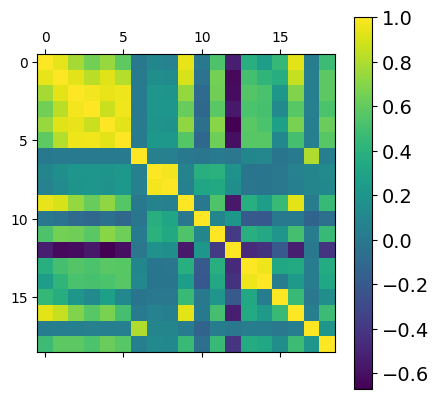

In [732]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')
plt.matshow(corr)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [733]:
le = LabelEncoder()
# le.fit(['Up', 'Down', 'Neutral'])
le.fit(['Up', 'Down', 'Neutral', 'Unknown'])
y_train = le.transform(y_train)
# y_valid = le.transform(y_valid)
y_test = le.transform(y_test)
# le.transform(['Up', 'Down', 'Neutral'])
le.transform(['Up', 'Down', 'Neutral', 'Unknown'])

array([3, 0, 1, 2])

In [734]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [735]:
rus = RandomUnderSampler(random_state=42)
X_test, y_test = rus.fit_resample(X_test, y_test)

(array([4258., 4258., 4258., 4258.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

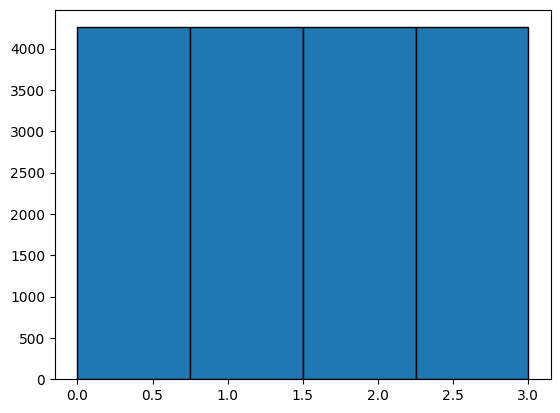

In [736]:
# plt.hist(y_train, bins=3, edgecolor='black')
plt.hist(y_train, bins=4, edgecolor='black')

(array([755., 755., 755., 755.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

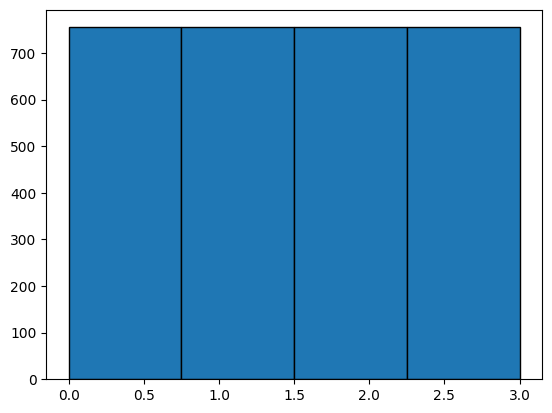

In [737]:
# plt.hist(y_test, bins=3, edgecolor='black')
plt.hist(y_test, bins=4, edgecolor='black')

In [738]:
%%time

param_grid = {
    'max_depth': [8],
    'learning_rate': [0.1],
    'n_estimators': [500],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8, 1.0],
}

# model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Thiết lập GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Tối ưu hóa dựa trên accuracy
    n_jobs=3, 
    verbose=1
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

# In tham số tốt nhất và điểm số
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.6}
Best Cross-Validation Accuracy: 0.5674628113758702
CPU times: total: 57.5 s
Wall time: 1min 7s


In [739]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.3464

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.29      0.31       755
           1       0.41      0.34      0.37       755
           2       0.45      0.24      0.31       755
           3       0.29      0.52      0.37       755

    accuracy                           0.35      3020
   macro avg       0.37      0.35      0.34      3020
weighted avg       0.37      0.35      0.34      3020


Confusion Matrix:
[[216 126 100 313]
 [120 259  31 345]
 [161 122 180 292]
 [150 123  91 391]]


In [740]:
le.transform(['Up', 'Down', 'Neutral'])
le.transform(['Up', 'Down', 'Neutral', 'Unknown'])

array([3, 0, 1, 2])

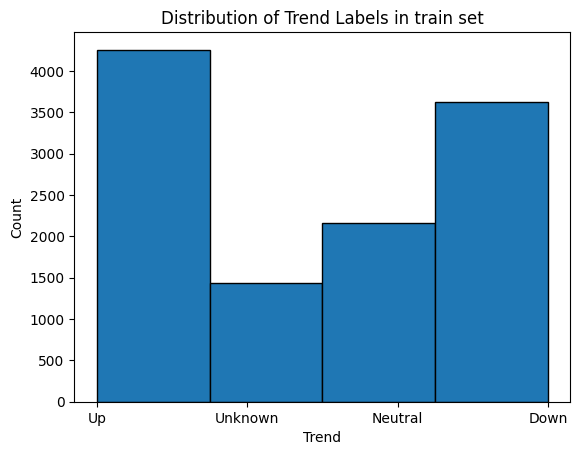

In [741]:
# plt.hist(train_df['Trend'], bins=3, edgecolor='black')
plt.hist(train_df['Trend'], bins=4, edgecolor='black')
plt.title('Distribution of Trend Labels in train set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

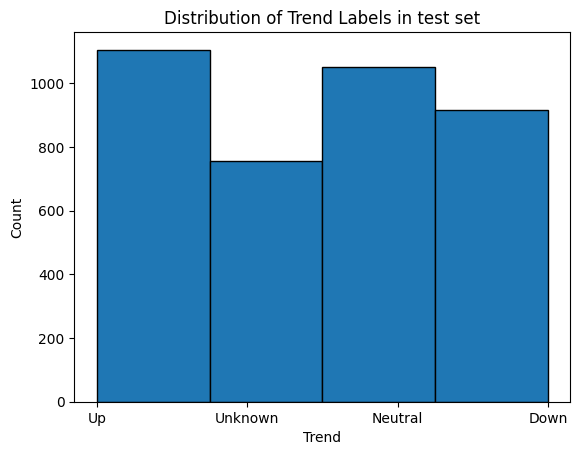

In [742]:
# plt.hist(test_df['Trend'], bins=3, edgecolor='black')
plt.hist(test_df['Trend'], bins=4, edgecolor='black')
plt.title('Distribution of Trend Labels in test set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

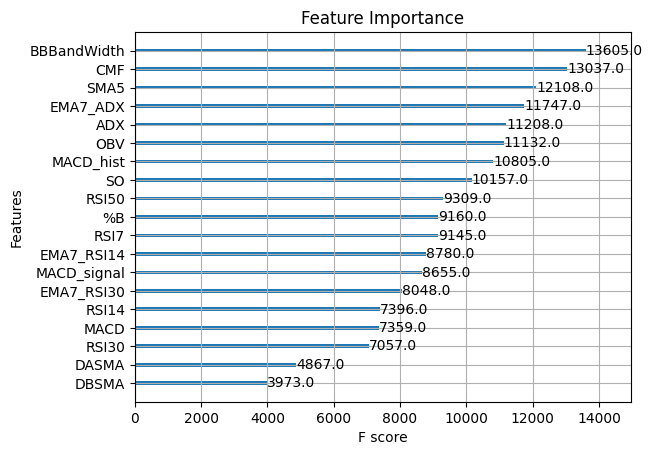

In [743]:
xgb.plot_importance(best_model)
plt.title('Feature Importance')
plt.show()